Restarted GenAMM (Python 3.11.4)

In [1]:
import pickle
import qGaussian
import qPowerLaw
import qlogNormal
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
from scipy.stats import kstest
import matplotlib.pyplot as plt
from tradingstrategy.client import Client
from tradingstrategy.timebucket import TimeBucket
sns.set_theme()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

dataset_path = '../data/usdc_weth_005.pickle'
with open(dataset_path, 'rb') as f:
    df = pickle.load(f)
df.index = pd.to_datetime(df.index)

df = df[ (df.index >= datetime(2023, 1, 1, 0, 0, 0)) & (df.index < datetime(2024, 1, 1, 0, 0, 0)) ]
df_swap = df[ (df.Event=='Swap_X2Y') | (df.Event=='Swap_Y2X') ]
df_mint = df[ df.Event=='Mint' ]
df_burn_mint = df[ (df.Event=='Burn') | (df.Event=='Mint') ]
df_burn = df[ df.Event=='Burn' ]

'''
df_burn_mint_full = df_burn_mint.copy()
df_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]
df_swap_full = df_swap.copy()
df_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]
'''

"\ndf_burn_mint_full = df_burn_mint.copy()\ndf_burn_mint = df_burn_mint[['block_number', 'Event', 'tick_lower', 'tick_upper', 'amount0', 'amount1', 'amount']]\ndf_swap_full = df_swap.copy()\ndf_swap = df_swap[['block_number', 'Event', 'tick', 'liquidity', 'amount0', 'amount1', 'amount']]\n"

Correlation L.O. delta block vs liquidity: -0.08033340827467018
Removing small outliers: 0.842833479489428 %


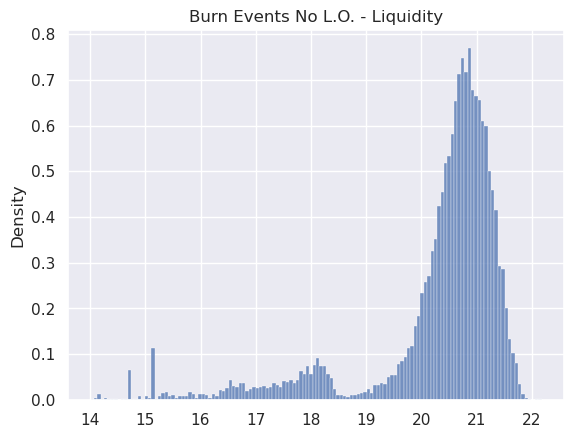

In [2]:
# Import L.O. data
with open('../data/burn_lo.pickle', 'rb') as f:
    burn_lo = pickle.load(f)

burn_lo[[
    'block_start'
    ]] =burn_lo[[
        'block_start']].astype(int)
burn_lo[[
    'amount'
    ]] =burn_lo[[
        'amount']].astype(np.float32)

lo_log_liquidity = np.log(burn_lo.amount.values)
print('Correlation L.O. delta block vs liquidity:',
      np.corrcoef(burn_lo.block_start.diff().values[1:], lo_log_liquidity[1:])[0,1])

# Remove small outliers
print('Removing small outliers:',
       100*(lo_log_liquidity <= 14).sum()/len(lo_log_liquidity), '%')
lo_log_liquidity = lo_log_liquidity[ lo_log_liquidity > 14 ]
# Plot the data
sns.histplot(lo_log_liquidity, stat='density', label='Data')
plt.title("Burn Events No L.O. - Liquidity")
plt.show()

In [3]:
import numpy as np
from scipy.special import gamma as gamma_func

class qGMM():
    def __init__(self, n_components, q, max_iter=100, tol=1e-4):
        self.n_components = n_components
        # Check q
        if q>=3:
            raise ValueError('q must be < 3')
        self.q = q
        self.A = (5-3*self.q) / (3-self.q)
        self.max_iter = max_iter
        self.tol = tol

        # Compute the normalization constant for the q-Gaussian
        if self.q < 1:
            self.Aq = 2*np.sqrt(2*np.pi) * gamma_func(1/(1-self.q)) /\
                ( (3-self.q)*np.sqrt(1-self.q)*gamma_func((3-self.q)/(2*(1-self.q))) )
        elif self.q > 1:
            self.Aq = np.sqrt(2*np.pi) * gamma_func((3-self.q)/(2*(self.q-1))) /\
                ( np.sqrt(self.q-1) * gamma_func(1/(self.q-1)) )

    def _q_exp(self, z):
        if self.q != 1:
            temp = 1 + (1-self.q)*z
            return np.where(temp>0, temp**(1/(1-self.q)), 0)
        else:
            return np.exp(z)

    def _q_gaussian_pdf(self, x, mu, sigma2):
        # Compute the pdf
        if self.q != 1:
            pdf = self._q_exp( -(x-mu)**2 / (2*sigma2) ) / (np.sqrt(sigma2) * self.Aq)
        else:
            pdf = np.exp(-(x-mu)**2 / (2*sigma2)) / (np.sqrt(2*np.pi) * np.sqrt(sigma2))
        return pdf

    def fit(self, X, init_means=None, init_vars=None):
        # Check x
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        N = len(X)

        # Initialize parameters
        self.weights_ = np.ones(self.n_components) / self.n_components
        if isinstance(init_means, type(None)):
            self.means_ = X[np.random.choice(N, self.n_components, replace=False)]
        else:
            self.means_ = init_means
        if isinstance(init_vars, type(None)):
            self.vars_ = np.ones(self.n_components)*np.var(X)
        else:
            self.vars_ = init_vars
        '''quantiles = np.quantile(
            X, np.linspace(0,1,self.n_components+2))
        self.means_ = quantiles[1:-1]
        self.vars_ = np.array([
            np.mean([
                (quantiles[qu+1]-quantiles[qu])**2,
                (quantiles[qu]-quantiles[qu-1])**2
                ])for qu in range(1, self.n_components+1)
        ])
        print(self.means_, self.vars_)'''

        prev_log_likelihood = -np.inf
        flag = False
        for _ in range(self.max_iter):
            log_p_mat = self._estimate_weighted_log_prob(X)
            min_log_p_mat = np.min(log_p_mat)
            # E-step
            if min_log_p_mat == -np.inf:
                #print('Sono nel cerchio sbagliato')
                old_means, old_vars = self.means_.copy(), self.vars_.copy()
                p_mat = self._estimate_weighted_prob(X)
                c_mat = self._e_step_nolog(
                    X, p_mat)
                X_temp = X[ ~np.isnan(c_mat[:,0])]
                c_mat = c_mat[ ~np.isnan(c_mat[:,0]), :]
                # M-step
                self._m_step(X_temp, c_mat)
                # print(self.means_, self.vars_)
                # print(np.any(np.isnan(c_mat)))
            else:
                #print('Giusto')
                c_mat = self._e_step(X, log_p_mat)
                # M-step
                self._m_step(X, c_mat)

            # Check for convergence
            if min_log_p_mat == -np.inf:
                new_log_likelihood = self._log_likelihood_no_log(p_mat)
                if np.max(np.abs(old_means - self.means_)) < self.tol:
                    flag = True
                    break
                if np.max(np.abs(old_vars - self.vars_)) < self.tol:
                    flag = True
                    break
            else:
                new_log_likelihood = self._log_likelihood(log_p_mat)
                if np.abs(new_log_likelihood - prev_log_likelihood) < self.tol:
                    flag = True
                    break

            prev_log_likelihood = new_log_likelihood

        if flag:
            self.log_likelihood = new_log_likelihood
            self.bic = 2*self.n_components*np.log(N) - 2*self.log_likelihood
        else:
            print("qGMM fit did not converge.")
            self.log_likelihood = np.nan
            self.bic = np.nan
        #return self

    def _e_step_nolog(self, X, weighted_log_prob):
        log_prob_norm = np.sum(weighted_log_prob, axis=1)
        return weighted_log_prob / log_prob_norm[:, np.newaxis]

    def _e_step(self, X, weighted_log_prob):
        log_prob_norm = self._logsumexp(weighted_log_prob, axis=1)
        log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        return np.exp(log_resp)

    def _m_step(self, X, c_mat):
        C_vec = np.sum(c_mat, axis=0)
        self.weights_ = C_vec / C_vec.sum()
        self.means_ = np.dot(c_mat.T, X) / C_vec

        eps2 = (X[:, np.newaxis] - self.means_)**2
        self.vars_ = list()
        for k in range(self.n_components):
            self.vars_.append(
                np.vdot(c_mat[:,k], (X-self.means_[k])**2) * self.A / C_vec[k])
        self.vars_ = np.array(self.vars_)

    def _estimate_weighted_log_prob(self, X):
        log_probs = self._estimate_log_prob(X)
        augmented_log_price = np.array(
            list(np.log(self.weights_))*len(X)).reshape(-1,self.n_components)
        return (augmented_log_price + log_probs)

    def _estimate_log_prob(self, X):
        return np.array([np.log(self._q_gaussian_pdf(X, mu, var))
                         for mu, var in zip(self.means_, self.vars_)]).T

    def _estimate_weighted_prob(self, X):
        probs = np.array([
            self._q_gaussian_pdf(X, mu, var) for mu, var in zip(
                self.means_, self.vars_)]).T
        augmented_price = np.array(
            list(self.weights_)*len(X)).reshape(-1,self.n_components)
        return (augmented_price * probs)

    def _log_likelihood(self, log_p_mat):
        return self._logsumexp(log_p_mat, axis=1).sum()

    def _log_likelihood_no_log(self, p_mat):
        return np.log(np.sum(p_mat, axis=1)).sum()

    def _logsumexp(self, a, axis=None, keepdims=False):
        a_max = np.amax(a, axis=axis, keepdims=True)
        tmp = np.exp(a - a_max)
        '''if np.any(np.isnan(tmp)) and (not np.any(np.isnan(a_max))):
            print(f"NaNs in pdf: {self.means_}, {self.vars_}")
            print(np.max(a_max), np.min(a_max))
            print(np.max(a), np.min(a))
            print(np.any(np.isnan(a - a_max)))'''
        s = np.sum(tmp, axis=axis, keepdims=keepdims)
        out = np.log(s)
        if not keepdims:
            a_max = np.squeeze(a_max, axis=axis)
        out += a_max
        return out
    
    def pdf(self, z):
        return np.sum([self.weights_[k] * self._q_gaussian_pdf(
            z, self.means_[k], self.vars_[k]
            ) for k in range(self.n_components)], axis=0)

In [4]:
def optimize_qGMM(X, max_iter=1_000, tol=1e-6, seed=None):
    from scipy.optimize import Bounds
    from scipy.optimize import minimize

    def objective(q, X, max_iter, tol, seed):
        best_ll, best_bic, best_nc = -np.inf, np.inf, None
        for nc in [2, 3]:
            np.random.seed(seed)
            q_gmm = qGMM(n_components=nc, q=q, max_iter=max_iter, tol=tol)
            q_gmm.fit(X)
            if q_gmm.bic < best_bic:
                best_bic = q_gmm.bic
                best_ll = q_gmm.log_likelihood
                best_nc = nc
        if best_nc == 3:
            np.random.seed(seed)
            q_gmm = qGMM(n_components=4, q=q, max_iter=max_iter, tol=tol)
            q_gmm.fit(X)
            if q_gmm.bic < best_bic:
                best_bic = q_gmm.bic
                best_ll = q_gmm.log_likelihood
                best_nc = 4
        return -best_ll, best_nc
    
    initial_guess = 1.25
    bounds = Bounds(1e-6, 5/3-1e-6)
    result1 = minimize(lambda q: objective(q, X, max_iter, tol, seed)[0],
                      initial_guess, method='SLSQP', bounds=bounds)
    
    initial_guess = 0.9
    result2 = minimize(lambda q: objective(q, X, max_iter, tol, seed)[0],
                      initial_guess, method='SLSQP', bounds=bounds)

    result = result1 if result1.fun < result2.fun else result2
    return result.x, objective(result.x, X, max_iter, tol, seed)[1], result

qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
qGMM fit did not converge.
q

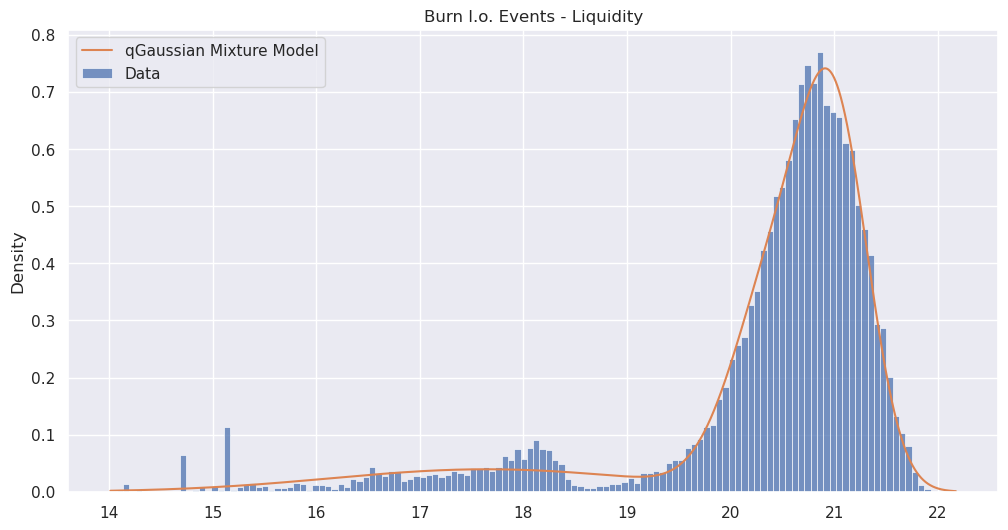

In [5]:
y_temp = lo_log_liquidity.copy()

opt_res = optimize_qGMM(y_temp, seed=2)
print(opt_res)

# Plot the best fit
q_gmm = qGMM(n_components=opt_res[1], q=opt_res[0], max_iter=2_000, tol=1e-6)
q_gmm.fit(y_temp)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(y_temp, ax=ax, stat='density', label='Data')

pdf = q_gmm.pdf( np.linspace(np.min(y_temp), np.max(y_temp), 10000) )

sns.lineplot(x=np.linspace(np.min(y_temp), np.max(y_temp), 10000),
             y=pdf,
            ax=ax, color=sns.color_palette()[1], label='qGaussian Mixture Model')

plt.title("Burn l.o. Events - Liquidity")
ax.legend()
plt.show()

No kernel connected